# Veryifying WheatFspm impulse experiments

The goal of this notebook is to verify that the experiment ran succesfully and that the reservoir experienced the impulse and changed trajectory.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
sys.path.insert(1, os.path.join(sys.path[0], '../../'))  # for importing local packages from src

### Loading the dataset

In [2]:
DATASET_PATH = '../datasets/dataset_NEMA3_impulse.csv'

In [3]:
from rc_dataset_impulse_cnwheat import ExperimentDataset

dataset = ExperimentDataset(csv_path=DATASET_PATH)
print(dataset)

Dataset properties:
	n_runs:      31
	n_steps:    1000
	state_size:  21

Available targets: 
	input_air_temperature, input_humidity, input_Wind, input_PARi, input_Unnamed: 0, output__axes__C_exudated, output__axes__SAM_temperature, output__axes__Total_Transpiration, output__axes__delta_teq, output__axes__delta_teq_roots, output__axes__mstruct, output__axes__sum_TT, output__axes__sum_respi_roots, output__axes__sum_respi_shoot, output__axes__teq_since_primordium, output__soils__Conc_Nitrates_Soil, output__soils__Tsoil, output__soils__mineralisation, output__soils__nitrates, output__organ_grains__R_grain_growth_starch, output__organ_grains__R_grain_growth_struct, output__organ_grains__S_Proteins, output__organ_grains__S_grain_starch, output__organ_grains__S_grain_structure, output__organ_grains__age_from_flowering, output__organ_grains__proteins, output__organ_grains__starch, output__organ_grains__structure, output__organ_phloem__amino_acids, output__organ_phloem__sucrose, output__organ_r

## Verifying experiment inputs

In [4]:
run_ids = dataset.get_run_ids()
run_params = [run_id.split('__') for run_id in run_ids]
run_params = [(date, int(width[-1]), int(value))for (_, date, width, value) in run_params]


def get_run_id(date, width, value):
  return f'{date}__{width}__{value}'

run_ids

array(['NEMA_H3__day0__width0__0', 'NEMA_H3__day18__width1__0',
       'NEMA_H3__day18__width1__4000', 'NEMA_H3__day18__width2__0',
       'NEMA_H3__day18__width2__4000', 'NEMA_H3__day18__width3__0',
       'NEMA_H3__day18__width3__4000', 'NEMA_H3__day18__width4__0',
       'NEMA_H3__day18__width4__4000', 'NEMA_H3__day18__width5__0',
       'NEMA_H3__day18__width5__4000', 'NEMA_H3__day27__width1__0',
       'NEMA_H3__day27__width1__4000', 'NEMA_H3__day27__width2__0',
       'NEMA_H3__day27__width2__4000', 'NEMA_H3__day27__width3__0',
       'NEMA_H3__day27__width3__4000', 'NEMA_H3__day27__width4__0',
       'NEMA_H3__day27__width4__4000', 'NEMA_H3__day27__width5__0',
       'NEMA_H3__day27__width5__4000', 'NEMA_H3__day9__width1__0',
       'NEMA_H3__day9__width1__4000', 'NEMA_H3__day9__width2__0',
       'NEMA_H3__day9__width2__4000', 'NEMA_H3__day9__width3__0',
       'NEMA_H3__day9__width3__4000', 'NEMA_H3__day9__width4__0',
       'NEMA_H3__day9__width4__4000', 'NEMA_H3__day9__width

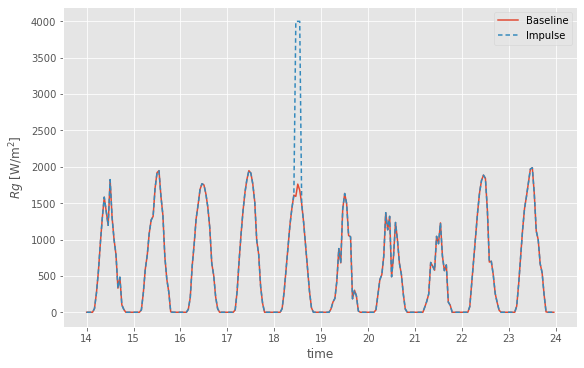

In [5]:
INPUT = 'input_PARi'
BASELINE = 'NEMA_H3__day0__width0__0'
EXPERIMENT = 'NEMA_H3__day18__width3__4000'

START = 24 * 14
END = START + 10 * 24


baseline_in = dataset.get_target(INPUT, BASELINE)[START:END]
experiment_in = dataset.get_target(INPUT, EXPERIMENT)[START:END]

with plt.style.context('ggplot'):
  fig, ax = plt.subplots(1, 1, figsize=(8, 5), constrained_layout=True)
  baseline_in.plot(ax=ax, label="Baseline")
  experiment_in.plot(ax=ax, dashes=(3, 2), label="Impulse")
  ax.set_xticks(np.arange(START, START + len(baseline_in) + 1, 24))
  ax.set_xticklabels(np.arange(START, START + len(baseline_in) + 1, 24) // 24)
  ax.set_ylabel('$Rg$ [W/m$^2$]')
  ax.legend(loc='upper right')

## Verifying reservoir deviation

In [6]:
sys.path.insert(1, os.path.join(sys.path[0], '../'))

from model_config_cnwheat import state_symbols, state_names, state_units, best_reservoirs, input_symbols

In [22]:
from sklearn.metrics import mean_squared_error


def nmse_distance(baseline, impulse):
  dist = np.empty(len(baseline))
  norm_factor = (baseline.var() + 1e-12)
  for i_step in range(len(baseline)):
    base_state = baseline[i_step]
    state = impulse[i_step]
    dist[i_step] = mean_squared_error(base_state, state) / norm_factor
  return dist


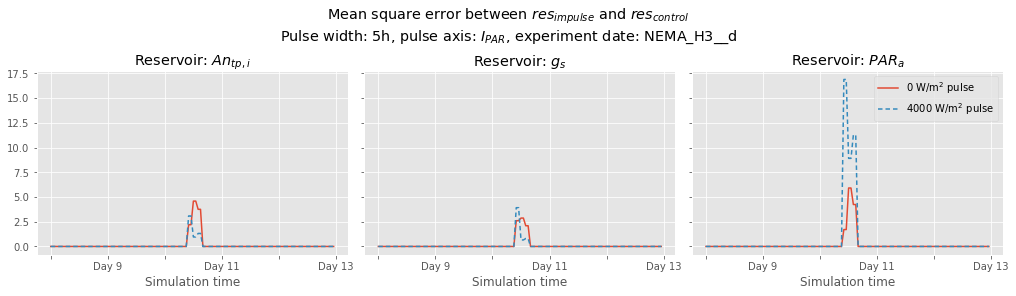

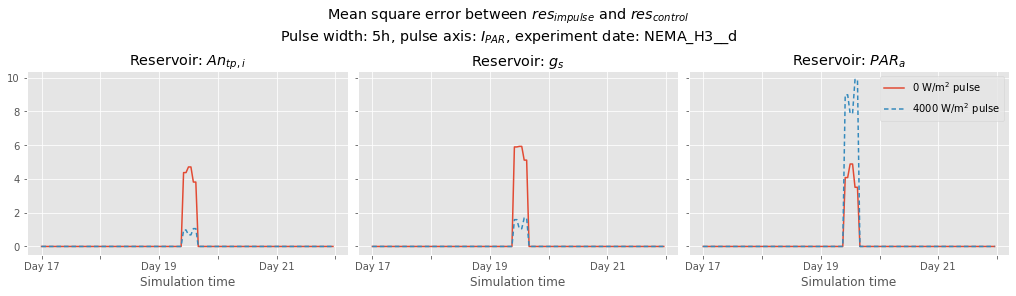

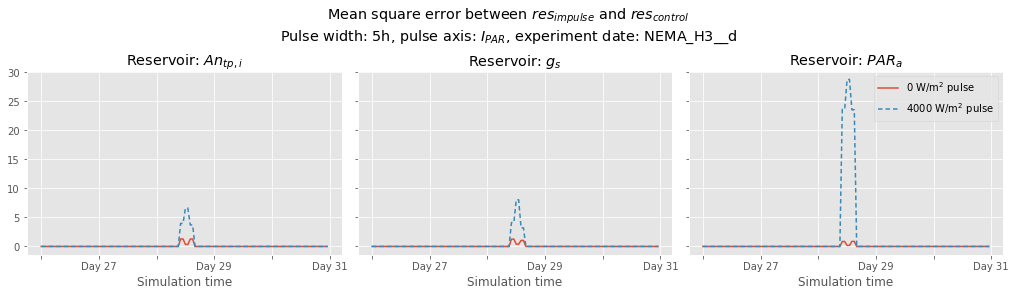

In [25]:

from sklearn.preprocessing import StandardScaler

INPUT = 'input_PARi'
BASELINE = 'NEMA_H3__day0__width0__0'
EXPERIMENT = 'NEMA_H3__day18__width3__4000'
STATES = ["state__An", "state__gs", "state__PARa"]

DATES = [9, 18, 27]

PULSE_WIDTH = 5
PULSE_VALUES = 0, 4000

plot_exps = [
  ('NEMA_H3__day0__width0__0', f'NEMA_H3__day9__width{PULSE_WIDTH}__'),
  ('NEMA_H3__day0__width0__0', f'NEMA_H3__day18__width{PULSE_WIDTH}__'),
  ('NEMA_H3__day0__width0__0', f'NEMA_H3__day27__width{PULSE_WIDTH}__'),
]

for (baseline, experiment), date in zip(plot_exps, DATES):

  START = (date - 2) * 24
  STOP = START + 5 * 24

  with plt.style.context('ggplot'):
    fig, axs = plt.subplots(1, 3, figsize=(14, 4), constrained_layout=True, sharey=True)

    for state, ax in zip(STATES, axs.flatten()):
      # process data
      baseline_state = dataset.get_state(state, baseline)[START:STOP]
      experiment_state_0 = dataset.get_state(state, experiment + '0')[START:STOP]
      experiment_state_4000 = dataset.get_state(state, experiment + '4000')[START:STOP]

      NaN = np.isnan(baseline_state)
      NaN_idx = np.any(NaN, axis=0)

      baseline_state = baseline_state[:, ~NaN_idx]
      experiment_state_0 = experiment_state_0[:, ~NaN_idx]
      experiment_state_4000 = experiment_state_4000[:, ~NaN_idx]
      
      # calculate NMSE as distance
      distance_0 = nmse_distance(baseline_state, experiment_state_0)
      distance_4000 = nmse_distance(baseline_state, experiment_state_4000)

      # plot data
      ax.plot(distance_0, label='0 W/m$^2$ pulse')
      ax.plot(distance_4000, dashes=(3,2), label='4000 W/m$^2$ pulse')
      ax.set_xticks(np.arange(0, STOP - START + 1, 24))
      ax.set_xticklabels([f'Day {int(t / 24 + 1)}' if t % 48 == 0 else '' for t in np.arange(START, STOP + 1, 24)])
      ax.set_xlabel('Simulation time')
      ax.set_title(f'Reservoir: {state_symbols[state]}')

      if ax is axs.flatten()[-1]:
        ax.legend(loc='upper right')
        # ax.text(4 * 24 + 11 - 5, 1, 'Impulse', rotation='vertical', transform='')

    fig.suptitle(f'Mean square error between $res_{{impulse}}$ and $res_{{control}}$'
                 f'\nPulse width: {PULSE_WIDTH}h, pulse axis: {input_symbols[INPUT]}, experiment date: {baseline[:10]}',
                 fontsize='x-large')



0.24771471223510247


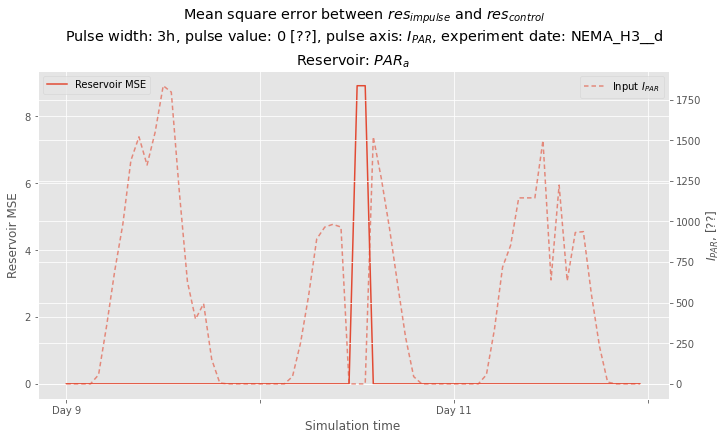

In [8]:
from sklearn.preprocessing import StandardScaler

BASELINE = 'NEMA_H3__day0__width0__0'
EXPERIMENT = 'NEMA_H3__day18__width3__4000'
STATES = 'state__PARa',


START = 24 * 3
STOP = 24 * 7

PULSE_WIDTH = 3
PULSE_VALUES = 0, 4000


DATES = [9, 18, 27]


plot_exps = [
  ('NEMA_H3__day0__width0__0', f'NEMA_H3__day9__width{PULSE_WIDTH}__'),
]

for (baseline, experiment), date in zip(plot_exps, DATES):

  START = (date - 1) * 24
  STOP = START + 3 * 24

  with plt.style.context('ggplot'):
    fig, axs = plt.subplots(1, 1, figsize=(10, 6), squeeze=False, constrained_layout=True, sharey=True)

    for state, ax in zip(STATES, axs.flatten()):
      # process data
      scaler = StandardScaler()

      baseline_state = dataset.get_state(state, baseline)[START:STOP]
      experiment_state_0 = dataset.get_state(state, experiment + '0')[START:STOP]
      experiment_input_0 = dataset.get_target('input_PARi', experiment + '0')[START:STOP]


      NaN = np.isnan(baseline_state)
      NaN_idx = np.any(NaN, axis=0)

      baseline_state = baseline_state[:, ~NaN_idx]
      experiment_state_0 = experiment_state_0[:, ~NaN_idx]
      
      scaler.fit(baseline_state)
      baseline_state = scaler.transform(baseline_state)
      experiment_state_0 = scaler.transform(experiment_state_0)

      distance_0 = np.mean(np.abs(baseline_state - experiment_state_0) ** 2, axis=1)

      print(distance_0[:72].mean())
      
      # plot data
      ax.plot(experiment_input_0.index, distance_0, label='Reservoir MSE')
      ax.set_ylabel('Reservoir MSE')
      twin = ax.twinx()
      twin.plot(experiment_input_0, alpha=0.6, dashes=(3,2), linewidth=1.5, label=f'Input {input_symbols["input_PARi"]}')
      twin.set_ylabel(f"{input_symbols['input_PARi']}, [??]")
      twin.legend(loc='upper right')
      # ax.set_xticks(np.arange(0, STOP - START + 1, 24))
      # ax.set_xticklabels([f'Day {int(t / 24 + 1)}' for t in np.arange(START, STOP + 1, 24)])
      # ax.axvline(4 * 24 - START + 11 + (PULSE_WIDTH // 2), color='black', dashes=(2,2), alpha=0.7, linewidth=1.25, label='Impulse interval')
      # ax.axvline(4 * 24 - START + 11 - (PULSE_WIDTH // 2), color='black', dashes=(2,2), alpha=0.7, linewidth=1.25)
      ax.set_xticks(np.arange(START, STOP + 1, 24))
      ax.set_xticklabels([f'Day {int(t / 24 + 1)}' if t % 48 == 0 else '' for t in np.arange(START, STOP + 1, 24)])
      ax.set_xlabel('Simulation time')
      ax.set_title(f'Reservoir: {state_symbols[state]}')
      ax.legend(loc='upper left')

    fig.suptitle(f'Mean square error between $res_{{impulse}}$ and $res_{{control}}$'
                 f'\nPulse width: {PULSE_WIDTH}h, pulse value: 0 [??], pulse axis: {input_symbols["input_PARi"]}, experiment date: {baseline[:10]}',
                 fontsize='x-large')

